 
  
   
<font size = 6><b><center> Dota Science</center></b></font>

<center>A machine learning approach to clustering player styles in DOTA2</center>
    




# Table of Contents

* Executive Summary
* Introduction
* Data Description and Collection (Recap)
* Exploratory Data Analysis (EDA)
* Dimensionality Reduction
* KMeans Clustering
* Feature Extraction
* Summary/Conclusion

# Executive Summary


DOTA2 is a highly complex game that is played between 2 teams of 5 opposing players, where each player can play any of 117 heroes available. This game typically poses challenges for both professional and casual players in choosing a teammate with a preferred "playing style" that would suit the team's needs. This study utilizes the unsupervised machine learning KMeans Clustering to be able to classify different "styles" of play from data collected from all 317 verified tournament players from https://www.dotabuff.com/. The results of the clustering identify 3 main clusters of playing styles: 

* <b>"Hard Carries"</b>, which is characterized by a skewed hero selection towards attack or "carry" heroes and typically have high kill rates and lower assist rates as well as being the highest ranked among the three clusters, with a median ranking of 121/317. Interestingly, most of the top 10 ranked verified tournament players belong to this cluster, perhaps showing that the ranking system is biased towards those with high games and kills.
* <b>"Versatile"</b>, which is characterized by mixed hero selection with both "carry" and "support" heroes being present in the top 5 heroes used in the cluster. These players also typically show relatively high kill rates but low number of games played, perhaps showing the lack of experience which may account for their "undecided" playing style. With regard to player rankings, they are rankged in the middle with a median ranking of 169/317.
* <b>"Hard Support"</b>, which is characterized by a strong preference to play "support" characters, and this is further supported by the top 5 heroes chosen in this cluster. This cluster shows high assist rates but low kill and death rates, that point to their playing style in game as being "support" characters that help the "carry" characters during the game. This cluster is also ranked the lowest, with its median rank being 185/317.

While the clustering was able to uncover 3 types of players, the limitations of this methodology is that there are no labels added and the granularity of the data is only until the lifetime averages of the players. A further study could be done on the match-per-match level using different supervised machine learning algorithms to create a more granular and accurate picture on the exact styles of the players. 

# Introduction: What is DOTA2?

<img src='dota-2-gameplay-ebetfinder-resized.jpg' width=600/>

Defense of the Ancients 2 of DOTA2 is a mobile online battle arena video game created by Valve that is played with 2 opposing teams of 5 members each. It is a sequel of the community-created mod, or modification, of the popular Warcraft III: Reign of Chaos expansion pack Frozen Throne from Blizzard Entertainment from 2003. As of 2018, DOTA2 was estimated to have earned north of 500 million US Dollars overall, and has since started to become one of the top games in the burgeoning e-sports industry. This has started to become a profitable industry in the gaming sector as DOTA2 has awarded approximately 181,440,811.06 US Dollars since its inception in 2013.


The two opposing teams in DOTA 2 are assigned a "side" of either Radiant or Dire, with the goal of capturing the opposing team's base at the end of the game. Each of the ten individual players select a hero at the beginning of the game, with each hero having their own set of skills, spells, and abilities that they can utilize to win the game. Each team of 5 players typically pick heroes for a game that will match each other's playing style and hero selection, in order to create a more unified and stronger team to beat the enemy. Due to the large number of combinations of teams, players, and heroes that are possible in DOTA2, professional teams and, to a certain extent, casual players typically have a hard time in finding that right "fit" of a player for their team. This complexity also presents a problem for machine learning algorithms and AI models that attempt to play DOTA2.

<img src='OG.jpg' width=400/>

Recent advances in AI models have allowed the team at OpenAI, funded by Elon Musk, to be able to train their system to play DOTA2 and beat the world's top players. However, even at the scale of OpenAI, these games come with certain asterisks as there are limitations to the amount of complexity in the game that OpenAI can play. These includes not being able to summon, no illusions, banned items, etc. with the added factor that OpenAI can only play 15 heroes of the 117 heroes well enough to compete at tournaments. This snapshot shows the challenges that professional teams run into when trying to choose a player style to match their team's play.

# Data Description and Collection (Recap)



# Exploratory Data Analysis

In [1]:
# import libaries
import csv
import re
import json
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import itertools
from time import sleep
from selenium import webdriver
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from kypy import cluster_range, intra_to_inter, plot_internal, plot_clusters

In [2]:
conn = sqlite3.connect('final_dota.db')
conn2 = sqlite3.connect('dota.db')
conn3 = sqlite3.connect('../dota_2.db')

# ANALYSIS STARTS HERE

### Insert uncorrelated columns here to subset the final dataframe below:

In [3]:
final = pd.read_sql('''SELECT * FROM player_summary''', conn).drop('index', 
                                                                   axis=1)

In [4]:
rank = final['rank']
players = final['PID']
final = final[['PID', 'Matches', 'ave_kills',
       'ave_death', 'ave_assist', 'Win Rate', 'KDA Ratio', 'GPM']]


In [5]:
stan_scaler = StandardScaler()
scaled = stan_scaler.fit_transform(final)

In [6]:
n = len(final.columns) - 1
pca = PCA(n_components=n)
pc = pca.fit_transform(scaled)
pc_cols = []
for i in range(n):
    pc_cols.append(f'pc{i+1}')
    
df_pc = pd.DataFrame(data = pc, columns=pc_cols)

Components: 0, explained variance: 0.0.
Components: 1, explained variance: 40.56190794776165.
Components: 2, explained variance: 61.00821256295641.
Components: 3, explained variance: 75.55681808231101.
Components: 4, explained variance: 86.36910973495088.
Components: 5, explained variance: 94.8852188244359.
Components: 6, explained variance: 98.0925783114899.


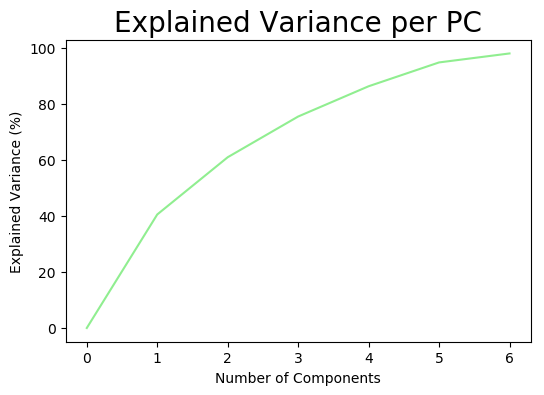

In [7]:
n = len(final.columns)
components_list = [i for i in range(n-1)]
var_ex = []
for n in components_list:
    pca_iter = PCA(n_components=n, random_state=1337)
    pca_iter.fit_transform(scaled)
    print(f'Components: {n}, explained variance: {pca_iter.explained_variance_ratio_.sum() * 100}.')
    var_ex.append(pca_iter.explained_variance_ratio_.sum() * 100)
fig, ax = plt.subplots(dpi=100)

ax.plot(components_list, var_ex, c='lightgreen')
ax.set_title('Explained Variance per No. of Components')
ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('Number of Components')
ax.set_title('Explained Variance per PC', fontsize=20);

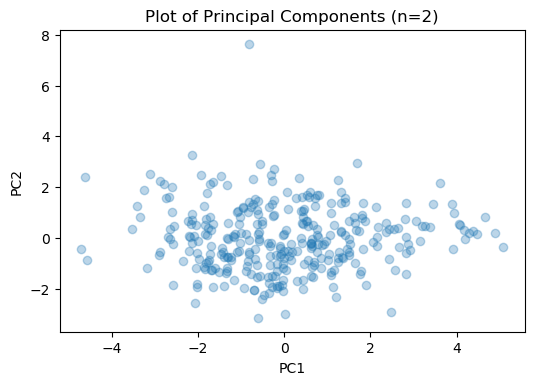

In [8]:
df_pc = df_pc.iloc[:,:3]
fig, ax = plt.subplots(dpi=100)
ax.scatter(df_pc.iloc[:,0], df_pc.iloc[:,1], alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Plot of Principal Components (n=2)');

In [9]:
result_X = cluster_range(df_pc.to_numpy(), KMeans(random_state=1337), 2, 6)

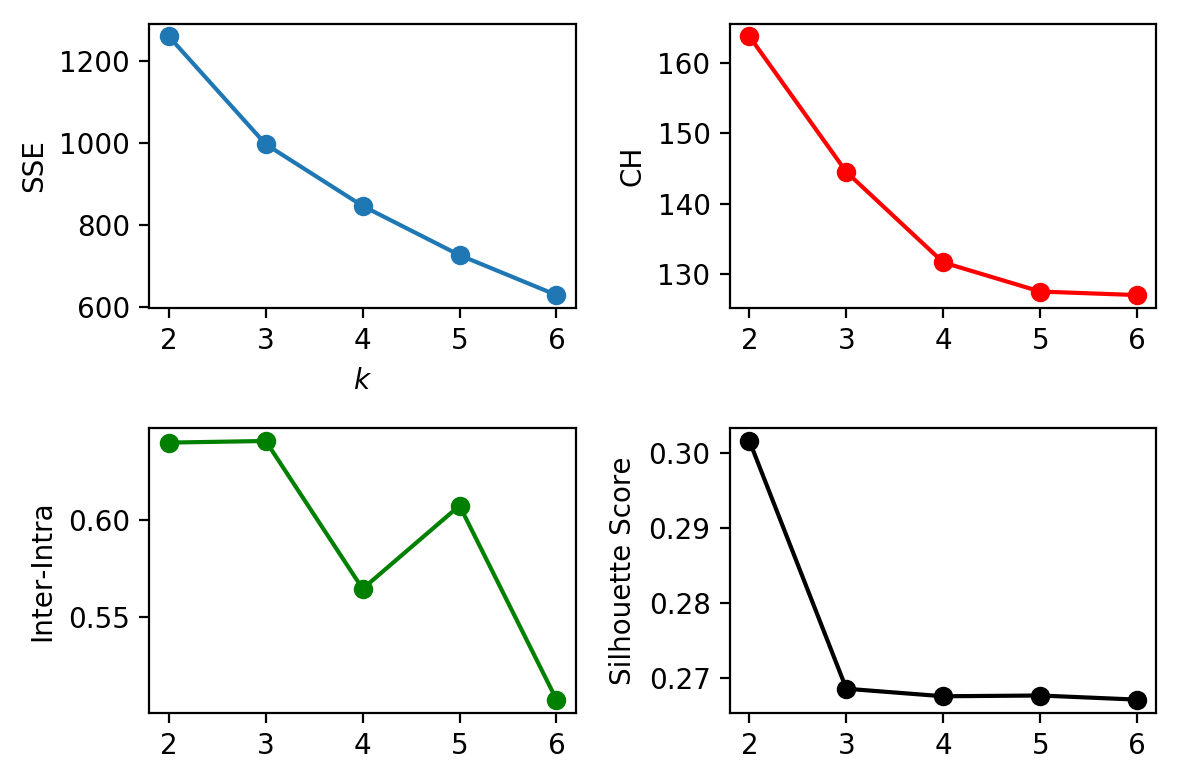

In [10]:
plot_internal(result_X['inertias'], result_X['chs'], result_X['iidrs'], result_X['scs']);

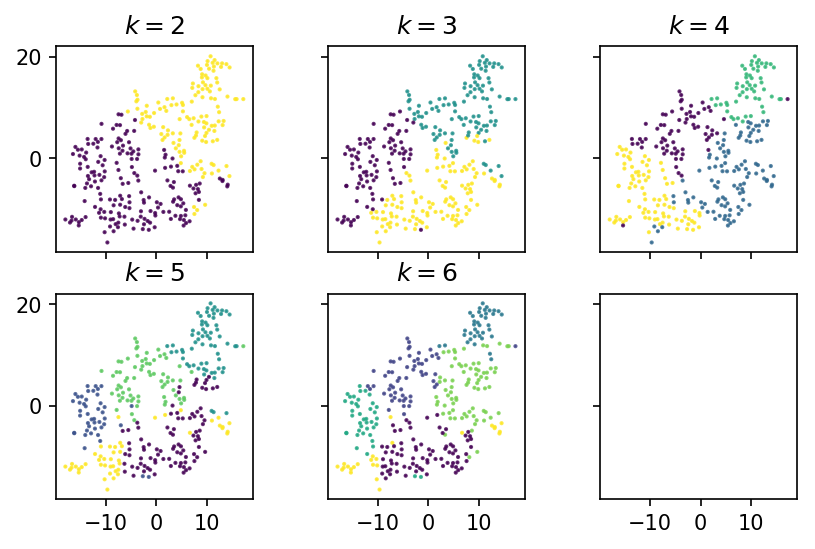

In [11]:
X_players_new = TSNE(n_components=2,random_state=1337).fit_transform(df_pc)
plot_clusters(X_players_new, result_X['ys']);

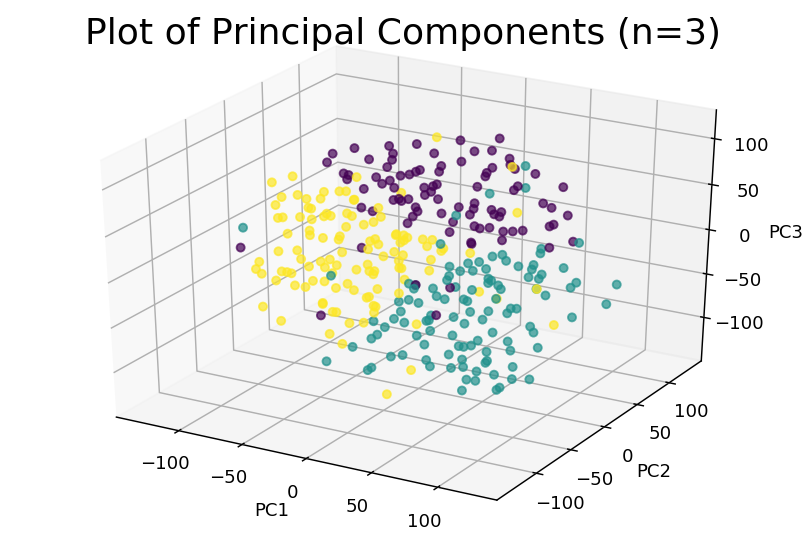

In [12]:
from mpl_toolkits.mplot3d import Axes3D
X_players_new = TSNE(n_components=3,random_state=1337).fit_transform(df_pc)
fig = plt.figure(dpi=130)
ax = Axes3D(fig)
ax.scatter(X_players_new[:,0], X_players_new[:,1], X_players_new[:,2], c=result_X['ys'][1], alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Plot of Principal Components (n=3)', fontsize=20);

In [13]:
kmeans = KMeans(n_clusters=3, random_state=1337)
y = kmeans.fit_predict(df_pc)

In [14]:
final['cluster'] = y

Count of Players per Cluster
Cluster 2: 117
Cluster 1: 111
Cluster 0: 89


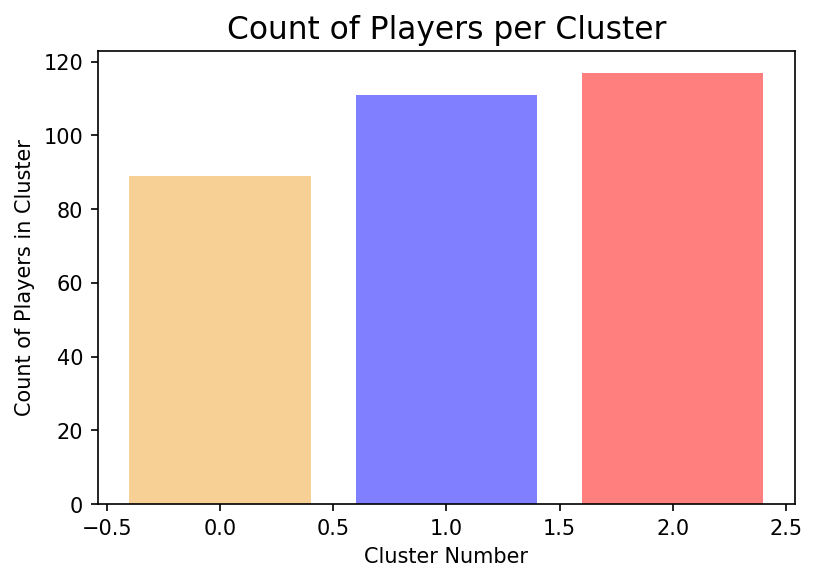

In [15]:
fig, ax = plt.subplots(dpi=150)
ax.bar(Counter(final['cluster']).keys(), Counter(final['cluster']).values(), 
       color=['red', 'blue', '#EFA22C'], alpha=0.5)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Count of Players in Cluster')
ax.set_title('Count of Players per Cluster', fontsize=15)
print('Count of Players per Cluster')
for i in Counter(final['cluster']).keys():
    print(f'Cluster {i}: {Counter(final["cluster"])[i]}')

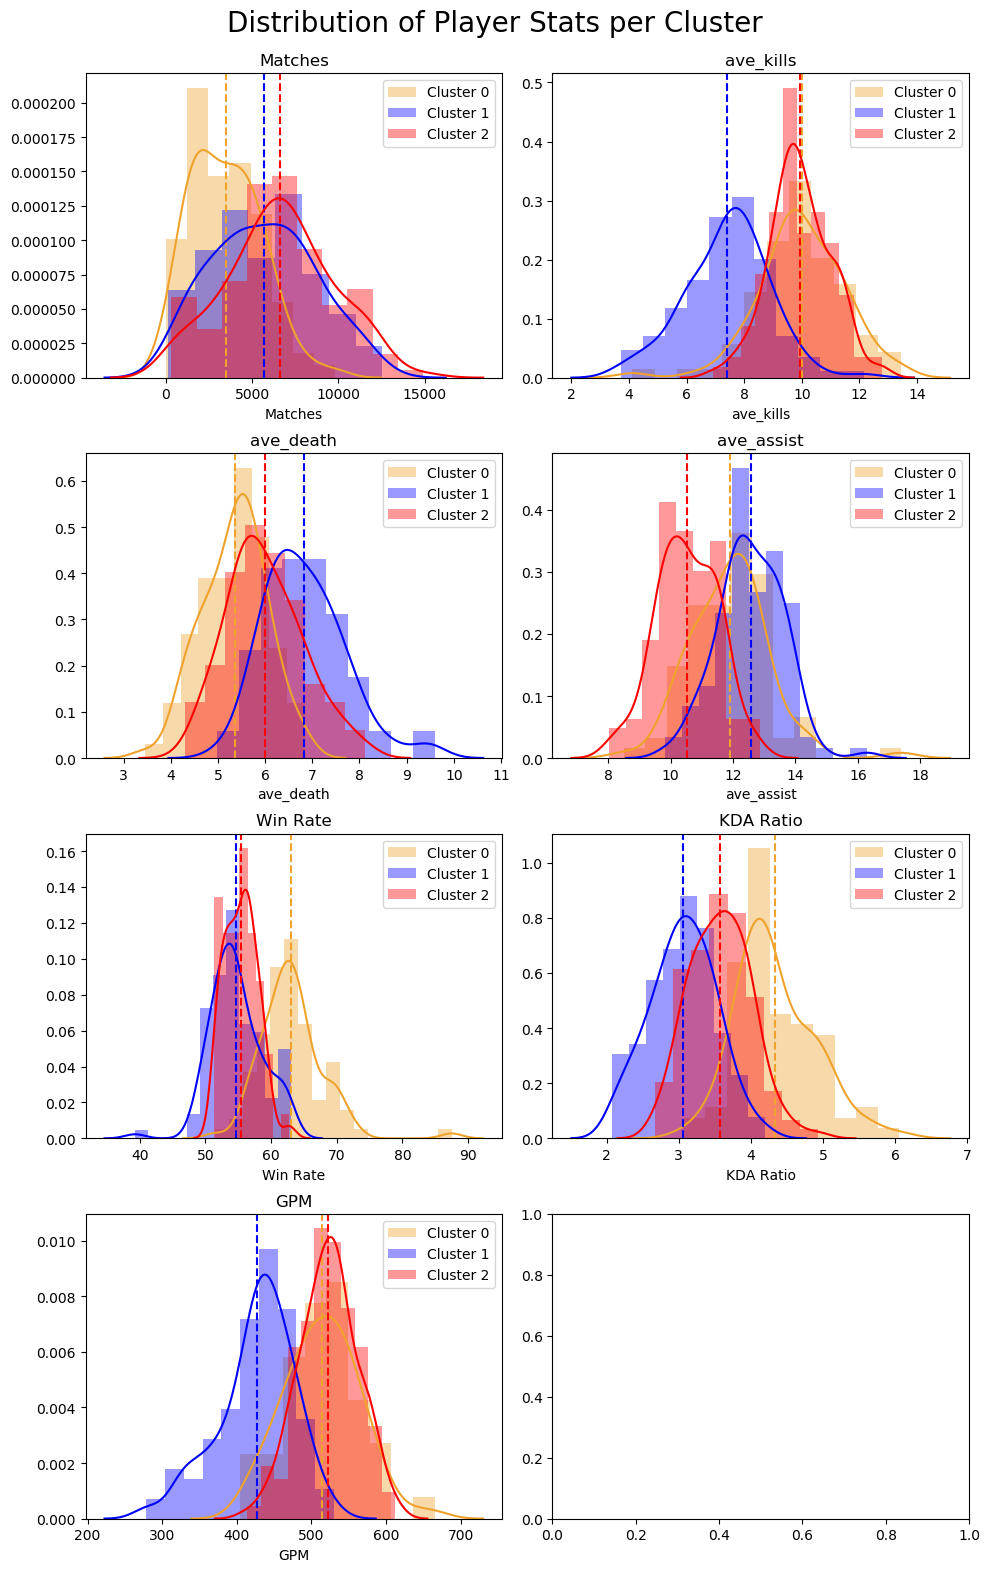

In [16]:
colors = ['#EFA22C', 'blue', 'red', 'orange']
stats = ['Matches', 'ave_kills', 'ave_death', 'ave_assist', 'Win Rate',
       'KDA Ratio', 'GPM']

if len(stats) % 2 == 1:
    figrows = (len(stats) // 2) + 1
else:
    figrows = (len(stats) // 2)

fig, ax = plt.subplots(figrows, 2, figsize=(10, figrows*4), dpi=100)


for i in range(final.cluster.nunique()):
    row = 0
    col = 0
    
    for j in stats:
        sns.distplot(final[final['cluster'] == i][j], ax=ax[row,col], 
                     color=colors[i], label=f'Cluster {i}')
        
        ax[row,col].axvline(final[final['cluster'] == i][j].mean(),
                           color=colors[i], ls='--')
        ax[row,col].legend()
        ax[row,col].set_title(j)

        if col == 1:
            row += 1
            col = 0

        else:
            col += 1
fig.suptitle('Distribution of Player Stats per Cluster', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [17]:
hero = pd.read_sql('''SELECT * FROM hero_summary''', conn).merge(final[['PID', 
                                                                'cluster']])

In [18]:
categories = hero.columns[118:132]

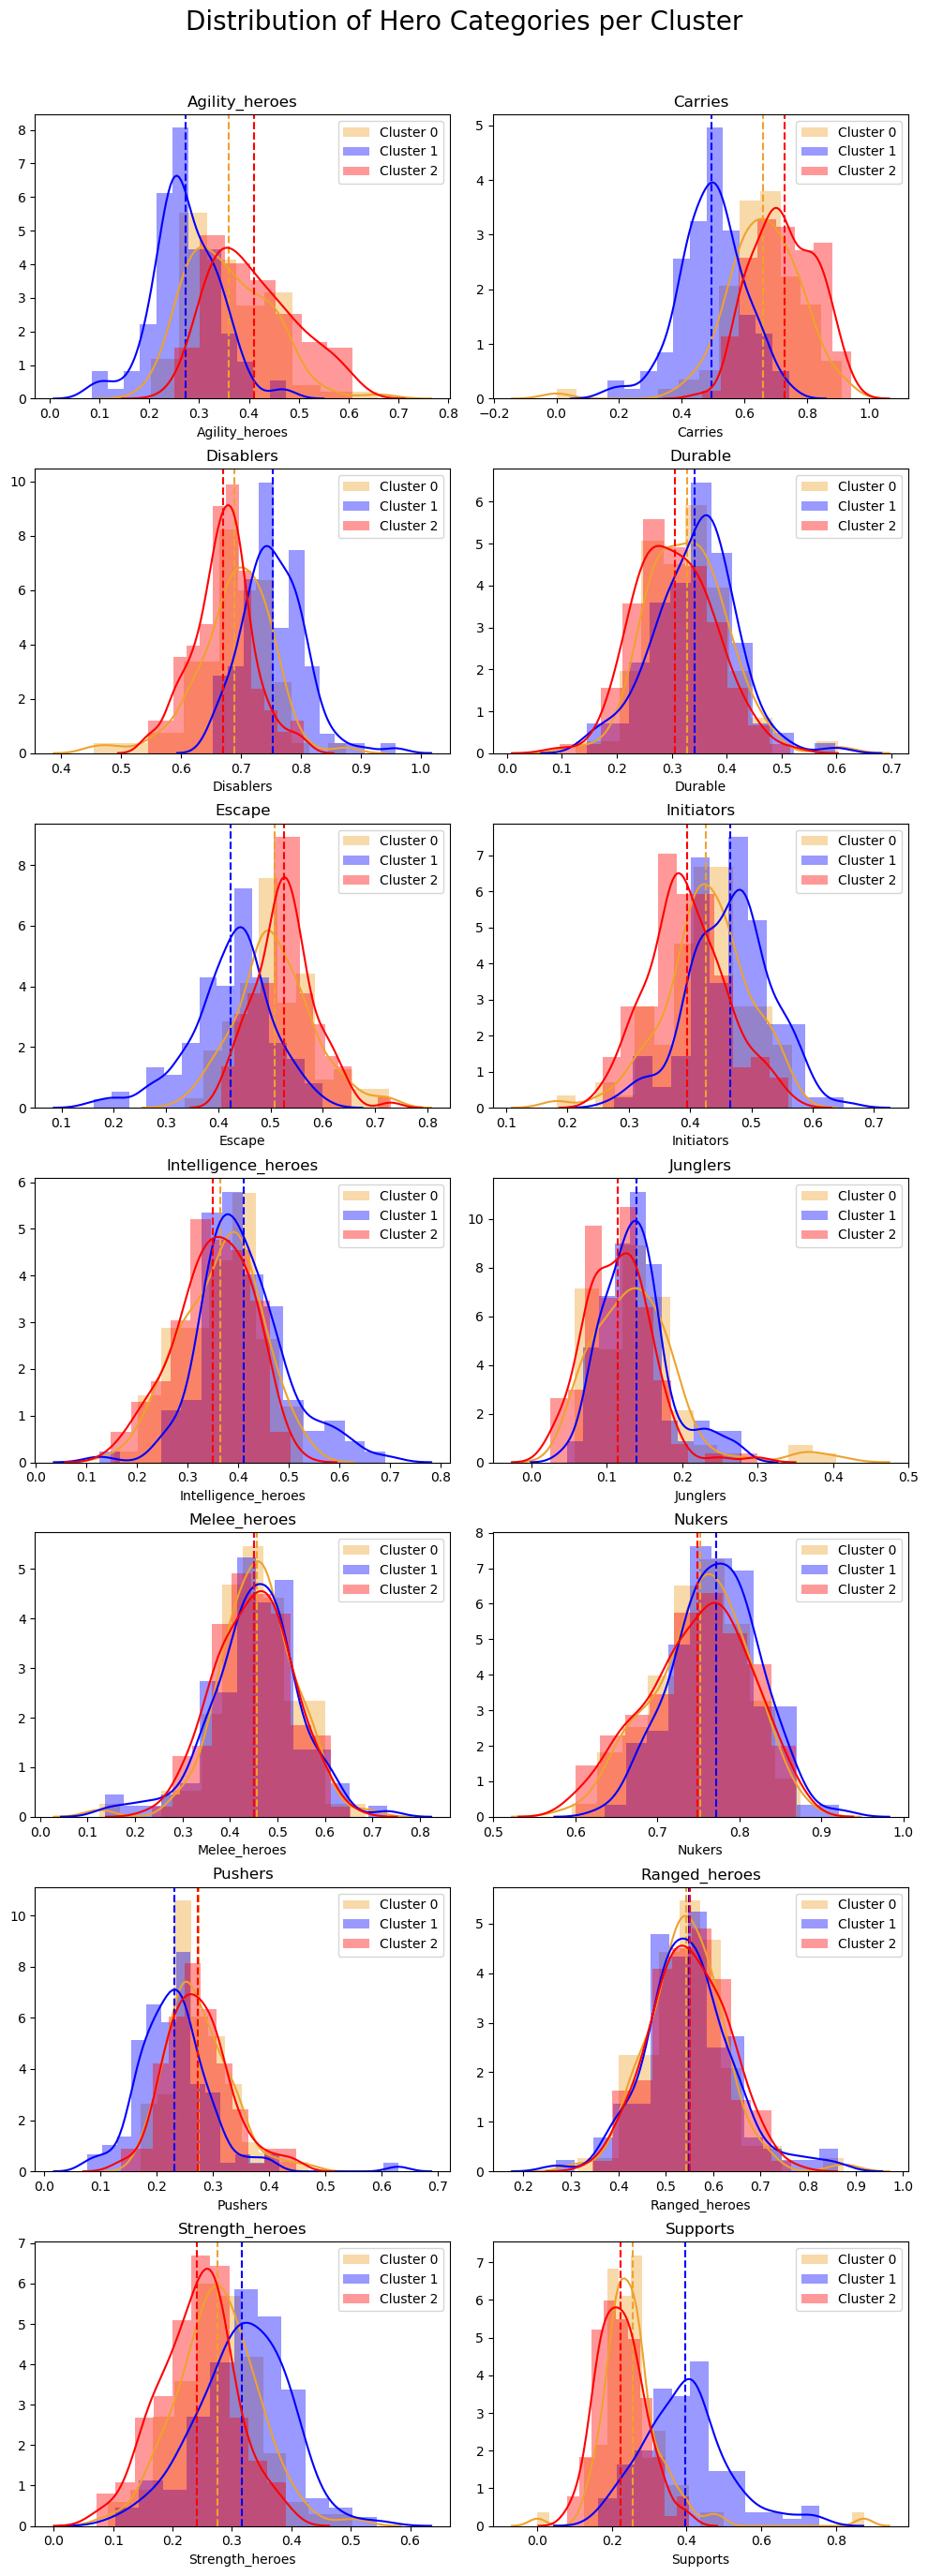

In [19]:
colors = ['#EFA22C', 'blue', 'red', 'orange']
stats = categories

if len(stats) % 2 == 1:
    figrows = (len(stats) // 2) + 1
else:
    figrows = (len(stats) // 2)

fig, ax = plt.subplots(figrows, 2, figsize=(10, figrows*4), dpi=100)


for i in range(hero.cluster.nunique()):
    row = 0
    col = 0
    
    for j in stats:
        sns.distplot(hero[hero['cluster'] == i][j], ax=ax[row,col], 
                     color=colors[i], label=f'Cluster {i}')
        
        ax[row,col].axvline(hero[hero['cluster'] == i][j].mean(),
                           color=colors[i], ls='--')
        ax[row,col].legend()
        ax[row,col].set_title(j)

        if col == 1:
            row += 1
            col = 0

        else:
            col += 1

fig.suptitle('Distribution of Hero Categories per Cluster', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [20]:
for stat in final.columns[1:8]:
    print(f'Stat: {stat}')
    for i in range(final['cluster'].nunique()):
        print(f'Cluster {i}: {round(final[final["cluster"]==i][stat].mean(), 2)}')
    print('\n')

Stat: Matches
Cluster 0: 3477.31
Cluster 1: 5674.86
Cluster 2: 6612.92


Stat: ave_kills
Cluster 0: 9.99
Cluster 1: 7.42
Cluster 2: 9.94


Stat: ave_death
Cluster 0: 5.35
Cluster 1: 6.83
Cluster 2: 6.0


Stat: ave_assist
Cluster 0: 11.89
Cluster 1: 12.56
Cluster 2: 10.53


Stat: Win Rate
Cluster 0: 63.11
Cluster 1: 54.71
Cluster 2: 55.43


Stat: KDA Ratio
Cluster 0: 4.33
Cluster 1: 3.06
Cluster 2: 3.58


Stat: GPM
Cluster 0: 514.42
Cluster 1: 426.61
Cluster 2: 522.68




In [21]:
final['rank'] = rank
print('Player Ranks for Clusters')
for i in range(final['cluster'].nunique()):
    print(f'Cluster {i} Median Rank:  {final[final["cluster"]==i]["rank"].median()}')

Player Ranks for Clusters
Cluster 0 Median Rank:  164.0
Cluster 1 Median Rank:  184.0
Cluster 2 Median Rank:  123.0


In [22]:
for i in range(final['cluster'].nunique()):
    print(f'Cluster {i} top ranked:\n{final[final["cluster"]==i].sort_values("rank", ascending=True)[["PID", "rank"]].head()}\n')

Cluster 0 top ranked:
           PID  rank
46    41231571     3
311  311360822     7
118   87278757     9
18    19672354    10
127   88585077    15

Cluster 1 top ranked:
           PID  rank
74    73562326    14
4      3916428    17
6      4281729    19
188  101356886    20
97    86727555    21

Cluster 2 top ranked:
           PID  rank
200  105248644     1
99    86745912     2
72    70388657     4
92    86700461     5
218  111620041     6



In [23]:
heroes = hero.columns[2:118]

In [24]:
print('Most Used Heroes per Cluster\n')
for i in range(hero['cluster'].nunique()):
    print(f'Cluster {i}')
    processor = hero[hero['cluster']==i][heroes].mean().to_list()
    for ind in np.argsort(processor)[::-1][:5]:
        print(hero[heroes].columns[ind])
    print('\n')


Most Used Heroes per Cluster

Cluster 0
Invoker
Shadow Fiend
Queen of Pain
Storm Spirit
Nature's Prophet


Cluster 1
Rubick
Invoker
Pudge
Mirana
Nature's Prophet


Cluster 2
Invoker
Storm Spirit
Shadow Fiend
Queen of Pain
Slark




In [25]:
print('Top Used Heroes per Cluster')
for i in hero['cluster'].unique():
    print(f'Cluster {i}')
    processor = hero[hero['cluster']==i][categories].mean().to_list()
    for j in np.argsort(processor)[::-1][:5]:
        print(hero[categories].columns[j])
    print('\n')

Top Used Heroes per Cluster
Cluster 2
Nukers
Carries
Disablers
Ranged_heroes
Escape


Cluster 1
Nukers
Disablers
Ranged_heroes
Carries
Initiators


Cluster 0
Nukers
Disablers
Carries
Ranged_heroes
Escape




# References and Acknowledgments

* https://www.esportsearnings.com/games/231-dota-2
* https://openai.com/five/
* https://www.dotabuff.com/